In [1]:
import torch
from torchvision import models
from torchvision import transforms
from torch import nn as nn 
import json
from PIL import Image

import os
import random

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score,roc_curve
import os
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
# This is for the progress bar.
import random

In [3]:
# Set different exp names 
torch.cuda.set_device(3)
device = "cuda" if torch.cuda.is_available() else "cpu"

myseed = 1213  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)


     

# 定義 Autoencoder 模型
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 25, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.Conv2d(25, 100, 4, stride=2, padding=1),        
            nn.ReLU(),
			nn.Conv2d(100, 400, 4, stride=2, padding=1),         
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(400, 100, 4, stride=2, padding=1),
            nn.ReLU(),
			nn.ConvTranspose2d(100, 25, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(25, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [4]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import cv2

_exp_name_='test_auto'


# Specify the output file path
output_file_path = f"{_exp_name_}_output_{myseed}_results.txt"
image_directorys=['semi_anlayic/raif_img_test','abnor_cat_dog/B']
labelss=[0,1]



# Open the output file in write mode
with open(output_file_path, 'w') as output_file:
    for image_directory,labels in zip(image_directorys,labelss):
        #image_directory = f"data/new data/spin/raw{md}_spin/{md}_a{spin}/"
        image_files = [f for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]

        model_best = Autoencoder().to(device)
        model_best.load_state_dict(torch.load(f'threshold_{myseed}_model.pth'))
        criterion = nn.MSELoss()
        model_best.eval()

        for image_file in image_files:
            #if image_files.endswith(('.jpg', '.jpeg', '.png')):
            
                # 組合完整的檔案路徑
                file_path = os.path.join(image_directory, image_file)

                # 讀取照片
                img = cv2.imread(file_path)
                if img is not None:
                    # 將照片 resize 到指定的尺寸
                    resized_img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
                    resized_img = torch.from_numpy(resized_img).permute(2, 0, 1).float().to(device)
                    labels = torch.tensor([labels], dtype=torch.float32).to(device)

                    with torch.no_grad():
                        outputs = model_best(resized_img.unsqueeze(0))  # 注意：在模型輸入中增加一個維度
                        loss = criterion(outputs, resized_img.unsqueeze(0))
                        scores = torch.mean(loss.view(1, -1), dim=1)

                    labels_np = labels.cpu().numpy()
                    scores_np = scores.cpu().numpy()

                    #print(scores_np, labels_np)

                    #fpr, tpr, thresholds = roc_curve(labels_np, scores_np)
                    #roc_auc = roc_auc_score(labels_np, scores_np)

                    #best_threshold_index = np.argmax(tpr - fpr)
                    #best_threshold = thresholds[best_threshold_index]
                    best_threshold = 6552.4926
                    predictions = (np.array(scores_np) > best_threshold).astype(int)
                    output_file.write(f'True label is {labels.item()}, Predicted label is {predictions.item()} for file {image_file}\n')




# Print a message indicating that the results have been saved
print(f"Results saved to {output_file_path}")


Results saved to test_auto_output_1213_results.txt


In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix

# 假設 aa.txt 的內容保存在一個變數中

# 將文本內容轉換為混淆矩陣
file_path = f'test_auto_output_{myseed}_results.txt'

def text_to_confusion_matrix(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    
    lines = content.strip().split('\n')
    #print(lines)
    true_labels = []
    predicted_labels = []
    for line in lines:
        # 解析每一行文本
        parts = line.split()
        # 找到 true label 和 predicted label 的索引
        true_label_index = parts.index('Predicted') - 1
        predicted_label_index = parts.index('for') - 1
        # 提取並轉換為浮點數
        true_label = float(parts[true_label_index].replace(',', ''))
        predicted_label = float(parts[predicted_label_index])
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)
    
    # 將列表轉換為 NumPy 陣列
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # 計算混淆矩陣
    confusion_mat = confusion_matrix(true_labels, predicted_labels)

    return confusion_mat

# 使用函數轉換文本內容為混淆矩陣
conf_matrix = text_to_confusion_matrix(file_path)

# 列印混淆矩陣
print("混淆矩陣：")
print(conf_matrix)



混淆矩陣：
[[283   0]
 [ 32 968]]


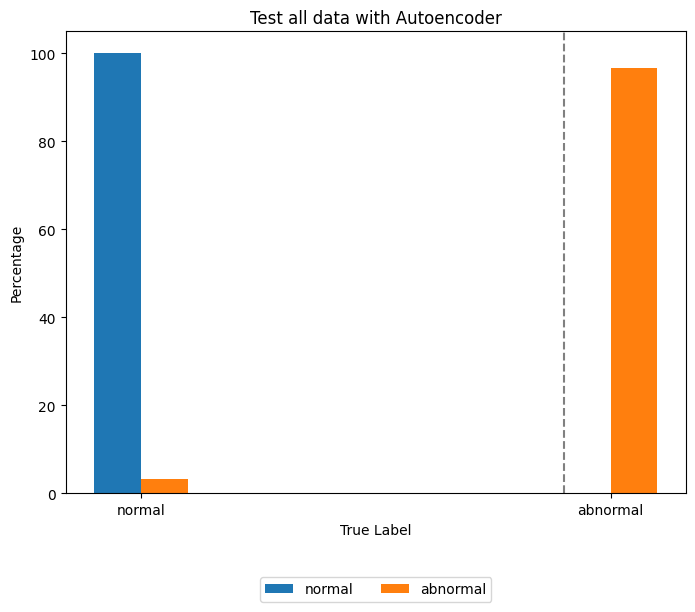

In [6]:
from sklearn.metrics import confusion_matrix
from PIL import Image

# 初始化混淆矩陣

cm_percentage = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100




# 设置 x 轴标签
x_labels = ['normal', 'abnormal']

# 转置百分比数据以匹配 Matplotlib 的要求
#percentages = np.array(percentages).T

# 创建条形图
fig, ax = plt.subplots(figsize=(8, 6))  # 設定圖形的大小
width = 0.1  # 条形宽度
x = np.arange(len(x_labels))

for i, label in enumerate(x_labels):
    #print(type(percentages[i]),label)
    ax.bar(x + i * width, cm_percentage[i], width, label=label)
    if i < len(x_labels) - 1:  # 在除最后一个标签之外的每个标签后面添加垂直线
        ax.axvline(x=(i + 1) - 0.05, color='gray', linestyle='--')

# 设置图表标签和标题
ax.set_xlabel('True Label')
ax.set_ylabel('Percentage')
ax.set_title(f'Test all data with Autoencoder')

# 设置 x 轴标签和图例
ax.set_xticks(x + width * (len(x_labels) - 1) / 2)
ax.set_xticklabels(x_labels)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)

fig.savefig(f'autoencoder_test_all_{myseed}.png', bbox_inches='tight') # 使用bbox_inches='tight'以確保完整保存圖片
plt.show()

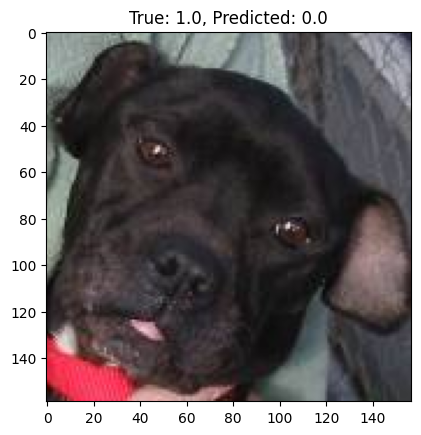

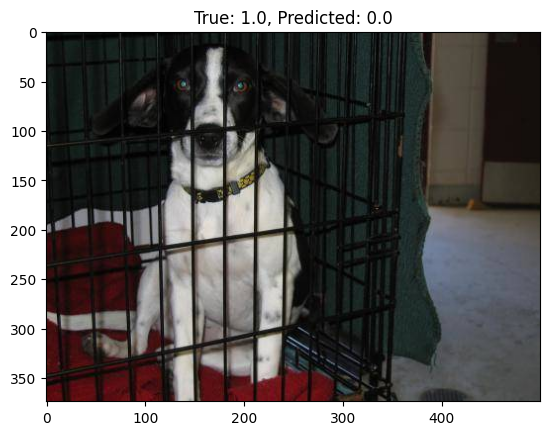

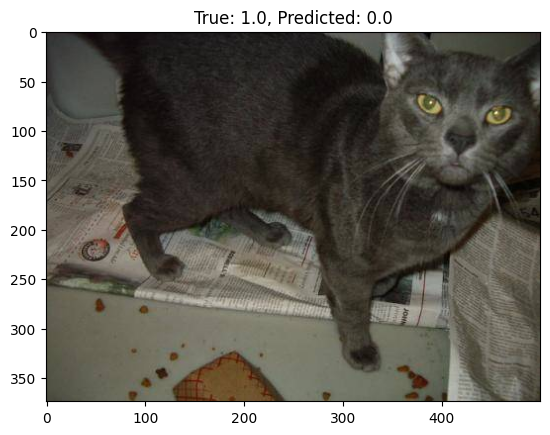

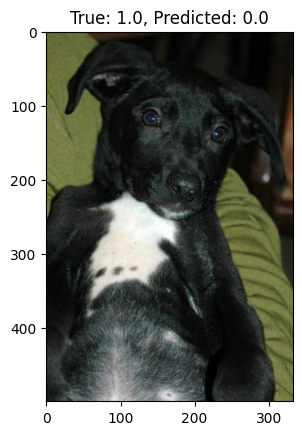

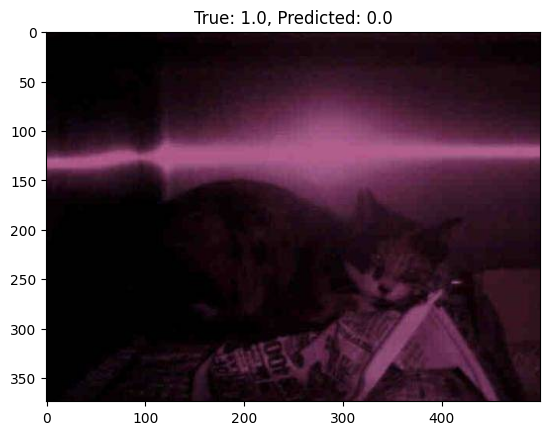

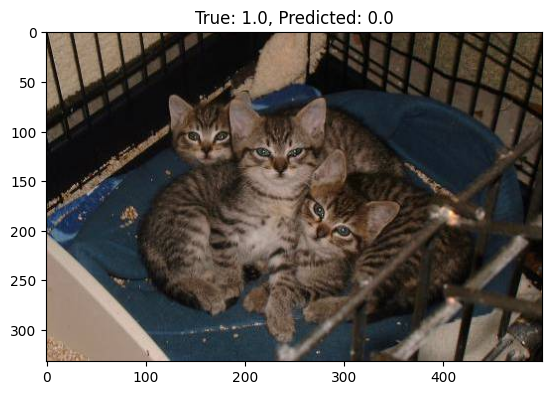

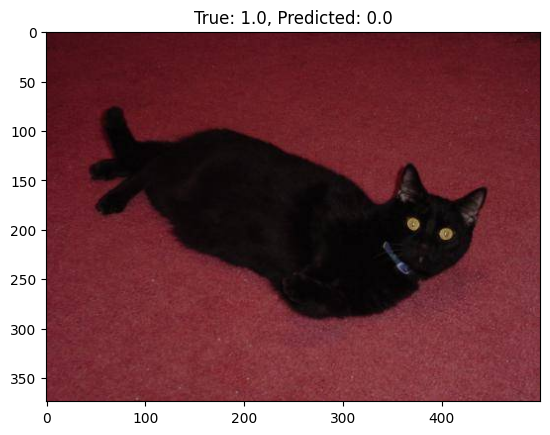

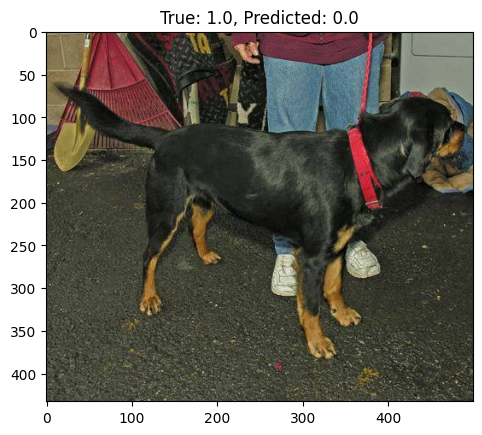

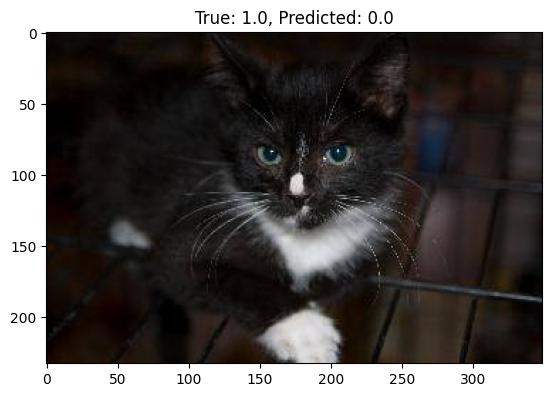

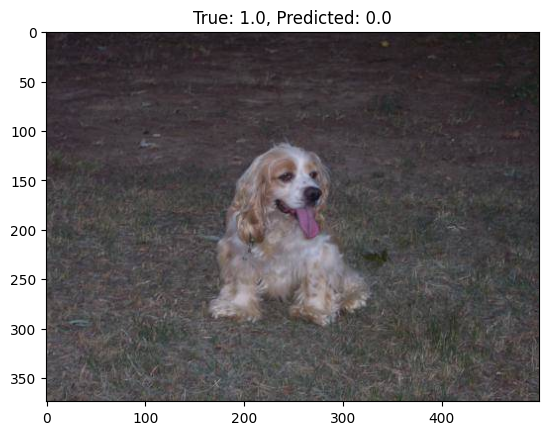

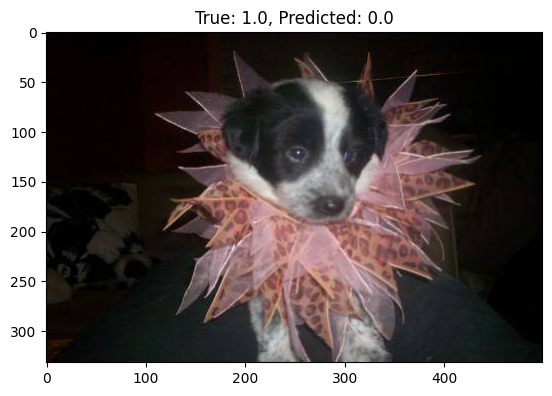

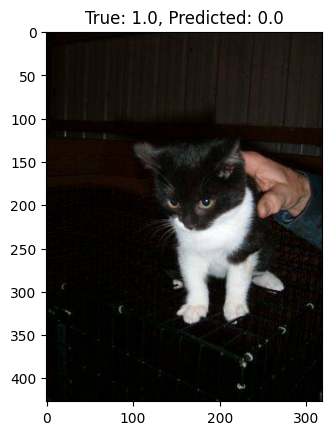

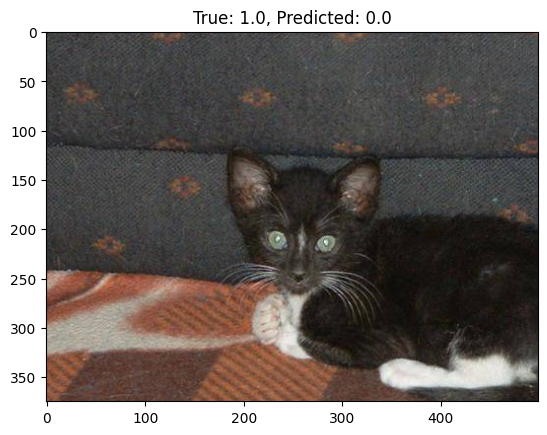

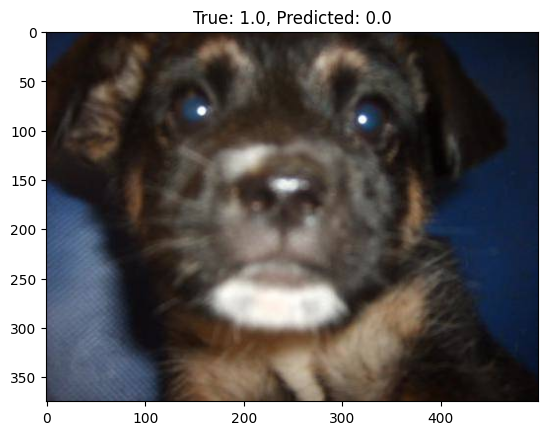

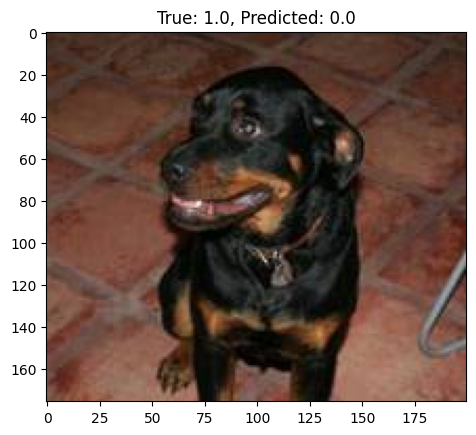

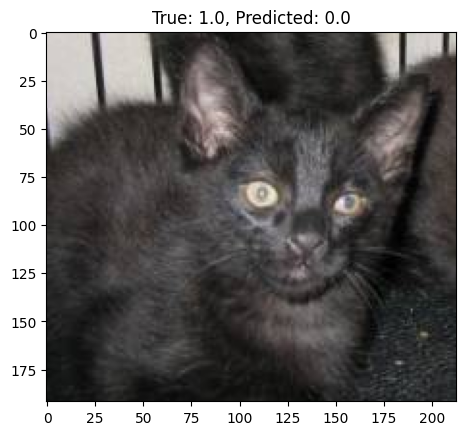

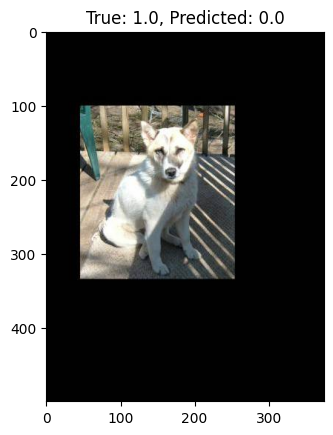

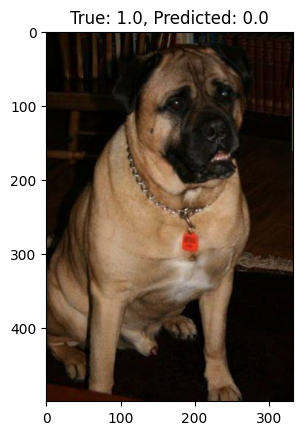

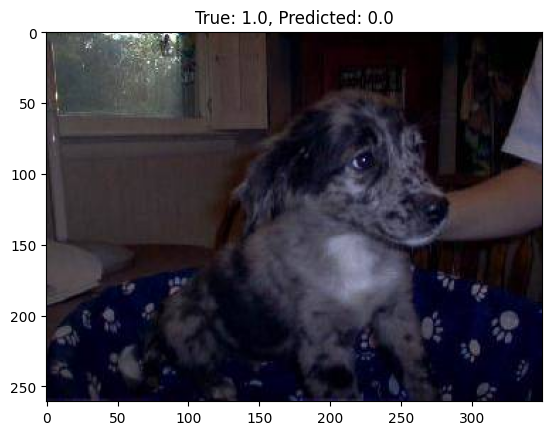

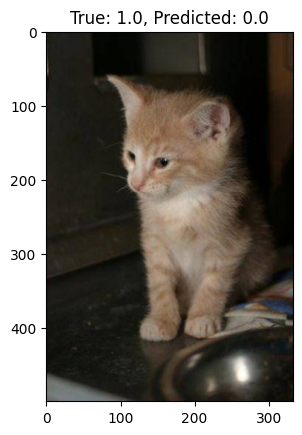

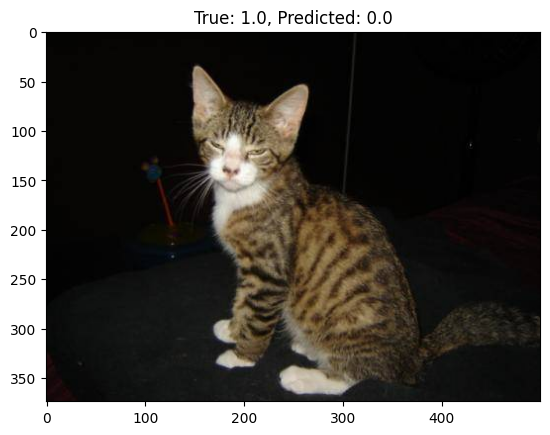

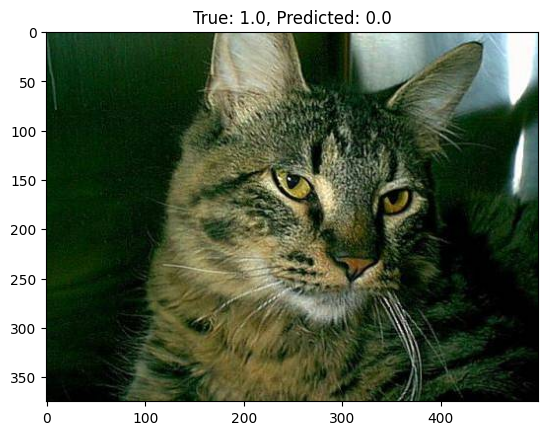

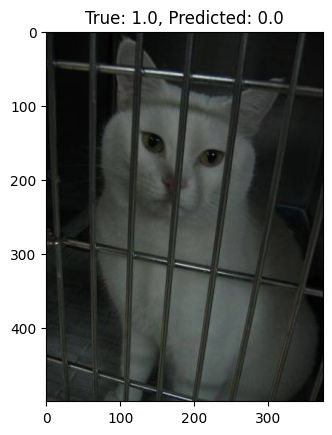

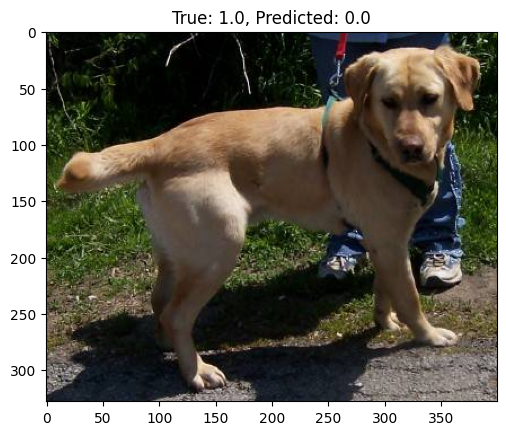

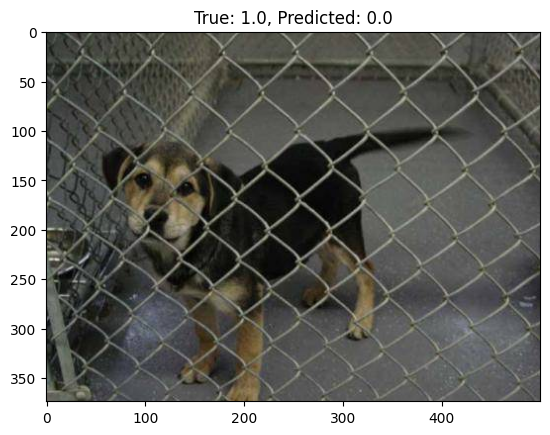

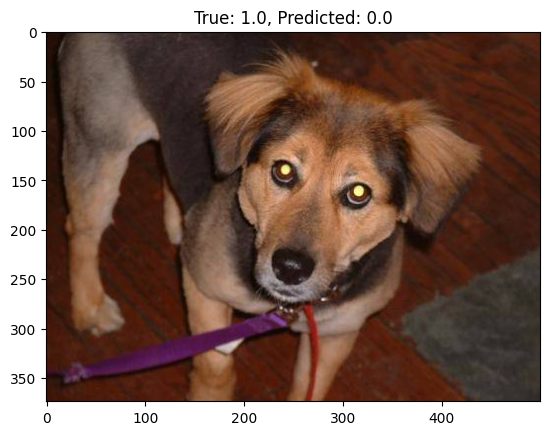

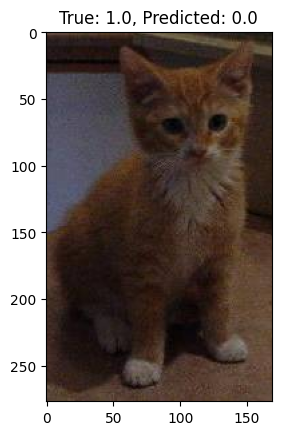

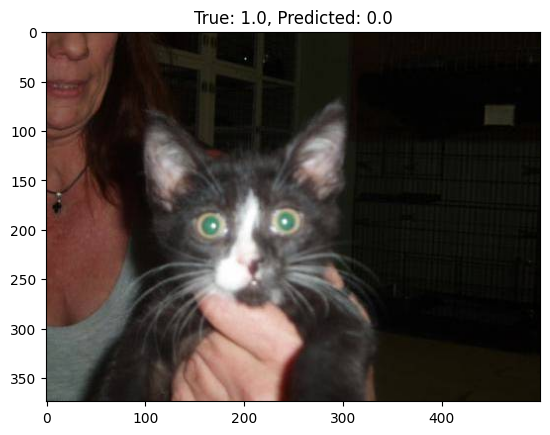

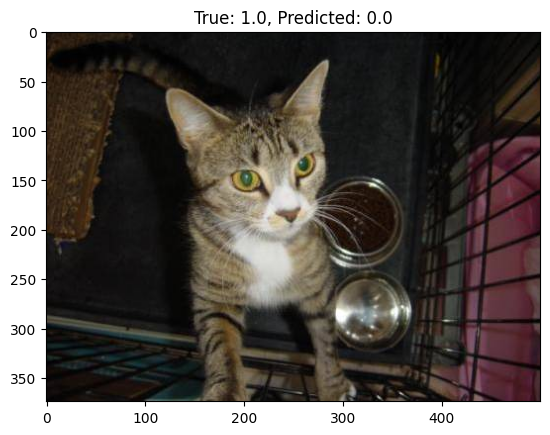

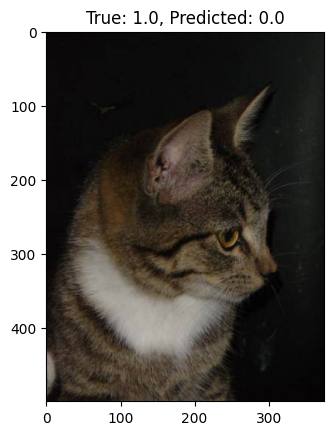

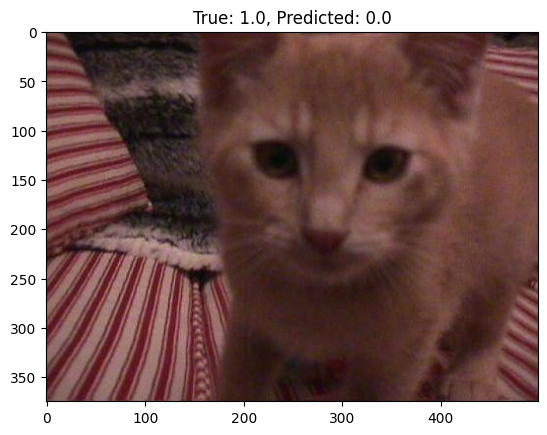

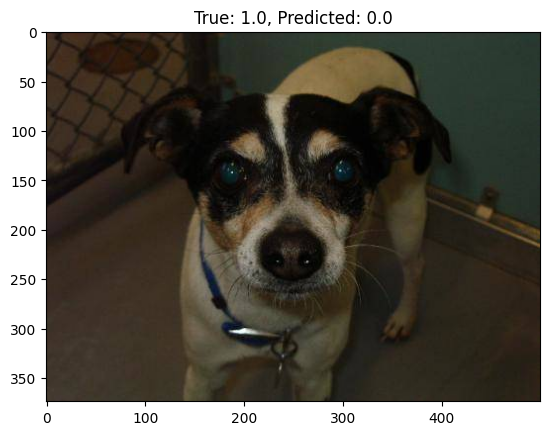

In [15]:
import matplotlib.pyplot as plt

file_path = f'test_auto_output_{myseed}_results.txt'

with open(file_path, 'r') as file:
    content = file.read()
    
    lines = content.strip().split('\n')
    #print(lines)
    true_labels = []
    predicted_labels = []
    for line in lines:
        # 解析每一行文本
        parts = line.split()
        # 找到 true label 和 predicted label 的索引
        true_label_index = parts.index('Predicted') - 1
        predicted_label_index = parts.index('for') - 1
        # 提取並轉換為浮點數
        true_label = float(parts[true_label_index].replace(',', ''))
        predicted_label = float(parts[predicted_label_index])
        if true_label == 1.0 and predicted_label == 0:
            file_name = parts.index('file') + 1
            file_index = parts[file_name]
            img_path = f'abnor_cat_dog/B/{file_index}'
            # 顯示影像
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f'True: {true_label}, Predicted: {predicted_label}')
            plt.show()
        